# Assignment 2 Classifying Flowers using Transfer Learning (VGG16 + Keras)

# Instructions:

Please follow all instructions carefully:

Download the small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rose, Sunflower, and Tulip). Images for each class are stored in its own folder. Note: if clicking on the above link does not trigger a download automatically, try copying the link into your browser.

The images have different dimensions. Resize all of them to match the pixel dimensions expected by VGG16,  e.g. 224x224 pixels.

Split images to 80-20% for training and test. Make sure you have the same distribution of flower types between train and test datasets.
Note: your test set should be held out until final evaluation, after you have finished optimizing your model. When trying different hyperparameters, please cut a separate validation split (10-20% of total training set size) from your training data to assess generalization importance. This can be done either manually or by passing the `validation_split` parameter to `model.fit()`.  A single validation split will suffice, you do not need to use full K-fold cross-validation for this assignment.

Use a VGG16 model (pre-trained on ImageNet) for transfer learning. Remove the top layers (fully connected layers).

Add your own fully connected layers (example: one with 256 nodes using ‘relu’ activation, and an output layer with 5 nodes and ‘softmax’ activation; the choice is up to you). You will train three different models and compare all three:
Model 1: First, freeze all layers of VGG16, train only the layers you added on top of it, and evaluate the model. Try your best to improve the model performance, and explain the reason behind any choices you make. You should experiment with different hyperparameters, such as the number of neurons or layers, optimizer type, and so forth. You can also apply regularization, batch normalization, or data augmentation as you see fit. Please show all steps, so we can follow the progression of your improvements to the model. Evaluate your model. You should report training, validation, and test accuracy (all three).
Model 2: Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model. You can keep the same set of best hyperparameters that you found while optimizing Model 1, or try new hyperparameters, it's up to you.
Model 3: Third, unfreeze all the layers and try again. Evaluate your model.

Compare the accuracy achieved between all three cases. Which one is better and why? Offer an explanation as to why performance is either better or worse in each case.

# Phase 0 – Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [148]:
import warnings
warnings.filterwarnings("ignore")
random_state=42

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Import tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import pathlib
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.image as mpimg
import random

# Phase 1 – Data Preparation

In [149]:
# Importing data directly from the URL
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=url, untar=True)
data_dir = pathlib.Path(data_dir)
data_dir = data_dir / 'flower_photos'
print(data_dir)
print(os.listdir(data_dir))

/root/.keras/datasets/flower_photos/flower_photos
['dandelion', 'daisy', 'LICENSE.txt', 'sunflowers', 'tulips', 'roses']


In [150]:
# List of path objects
all_images = list(data_dir.glob('*/*.jpg'))
all_images[:5]

[PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion/19691175559_ef12b8b354_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion/13942846777_5571a6b0a1_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion/477316928_a70a31a704_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion/2477986396_19da36d557_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion/493696003_f93ffb3abd_n.jpg')]

In [151]:
#List of labels
all_labels = [p.parent.name for p in all_images]
print(set(all_labels))

{'dandelion', 'tulips', 'roses', 'sunflowers', 'daisy'}


In [152]:
# Checking class balance is a crucial sanity step
# Using dictionary to show the count of each labels
label_counts = {}
for labels in all_labels:
  if labels in label_counts:
    label_counts[labels] += 1
  else:
    label_counts[labels] = 1
print(label_counts)

{'dandelion': 898, 'daisy': 633, 'sunflowers': 699, 'tulips': 799, 'roses': 641}


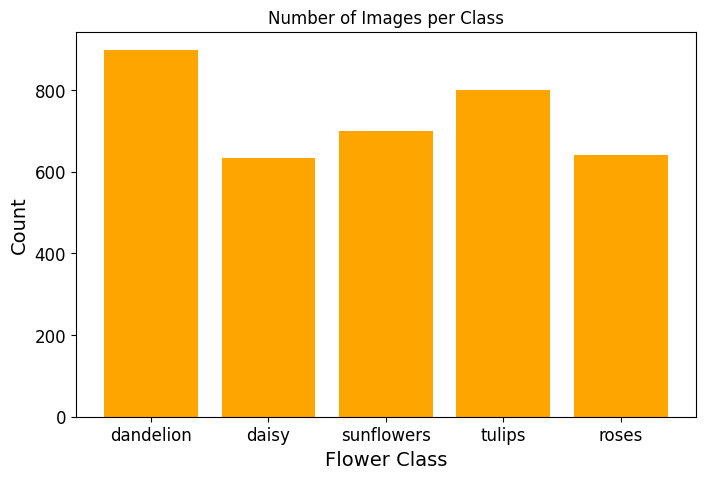

In [153]:
# Plotting the class balance
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='Orange')
plt.title('Number of Images per Class')
plt.xlabel('Flower Class')
plt.ylabel('Count')
plt.show()

Our dataset is sufficiently balanced to proceed safely with splitting (train/validation/test/) and model training.

In [154]:
# Neural networks cannot work directly with strings as labels. They require numerical representations.
# Convert string labels to integers
labels_list = sorted(list(set(all_labels)))
print(labels_list)
labels_dic = {name:index for index, name in enumerate(labels_list)}
print(labels_dic)
labels_index = [labels_dic[labels] for labels in all_labels]
print(labels_index)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [155]:
# Splitting the dataset
# 80% train, 20% test
train_files, test_files, train_labels, test_labels = train_test_split(all_images,labels_index,test_size=0.2,
                                                                      stratify=labels_index,random_state=42)
# 10% of train as validation
train_files, val_files, train_labels, val_labels = train_test_split(train_files,train_labels,test_size=0.1,
                                                                      stratify=train_labels,random_state=42)
print(len(train_files),len(val_files),len(test_files))

2642 294 734


In [156]:
# Make everything ready for VGG16 model
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def paths_labels_to_dataset(files, labels, num_classes=len(labels_list)):
    # Convert paths to strings
    files = [str(f) for f in files]

    # Convert integer labels to one-hot vectors
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((files, labels))

    # Load, decode, resize, and preprocess images
    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [157]:
# Make dataset ready for use
train_ds = paths_labels_to_dataset(train_files, train_labels)
val_ds = paths_labels_to_dataset(val_files, val_labels)
test_ds = paths_labels_to_dataset(test_files, test_labels)

PHASE 2 – Model 1: Transfer Learning with Frozen VGG16

In [158]:
# Load VGG16 without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all layers so they’re not trainable
for layer in base_model.layers:
  layer.trainable = False

base_model.summary() # optional, to inspect architecture

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [159]:
# Build new model on top of VGG16
model_1 = models.Sequential([
    base_model,                                # pretrained convolutional base
    layers.Flatten(),                          # convert feature maps to 1-D
    layers.Dense(256, activation='relu'),      # fully connected layer
    layers.Dropout(0.5),                       # prevent overfitting
    layers.Dense(5, activation='softmax')      # 5 flower classes
])

model_1.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

I started with 256 neurons in the dense layer because this size strikes a balance between model capacity and generalization for a medium-sized dataset like Flowers. Later, I will experiment with 128 and 512 neurons to observe effects on validation accuracy and overfitting.

In [160]:
# Compile the model
model_1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

For the optimizer, Adam is adaptive and works well for fine-tuning; I will later test RMSprop or SGD.

In [161]:
# Train the Model
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6326 - loss: 11.0421 - val_accuracy: 0.8367 - val_loss: 0.9710
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8432 - loss: 0.7568 - val_accuracy: 0.8571 - val_loss: 0.6938
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8750 - loss: 0.6248 - val_accuracy: 0.8197 - val_loss: 1.0045
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8869 - loss: 0.5840 - val_accuracy: 0.8469 - val_loss: 0.7074
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8985 - loss: 0.5469 - val_accuracy: 0.8435 - val_loss: 0.9212
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9125 - loss: 0.3913 - val_accuracy: 0.8469 - val_loss: 0.8250
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9036 - loss: 0.5847 - val_accuracy: 0.8469 - val_loss: 1.1291
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9306 - loss: 0.5483 - val_accuracy: 0.8776 - 

For the next improvement I will add "Early Stopping" to prevent that small overfitting and save training time.

In [162]:
# Stop training when validation loss doesn't improve for 3 consecutive epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9332 - loss: 0.4784 - val_accuracy: 0.8673 - val_loss: 1.0412
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9391 - loss: 0.2943 - val_accuracy: 0.8844 - val_loss: 0.9375
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9478 - loss: 0.2527 - val_accuracy: 0.8810 - val_loss: 1.1730
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9370 - loss: 0.3385 - val_accuracy: 0.8776 - val_loss: 0.9849
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9487 - loss: 0.3036 - val_accuracy: 0.8878 - val_loss: 0.8758
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9339 - loss: 0.3629 - val_accuracy: 0.8571 - val_loss: 1.0966
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9335 - loss: 0.2632 - val_accuracy: 0.8367 - val_loss: 0.7349
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9358 - loss: 0.3146 - val_accuracy: 0.8537 - v

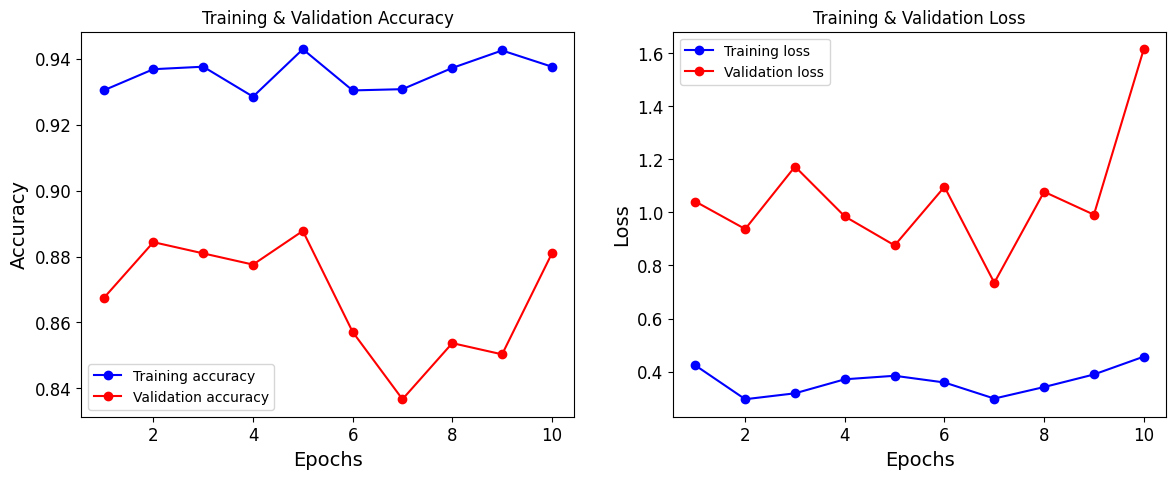

In [163]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [164]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8426 - loss: 0.7391
0.693882942199707 0.8487738370895386


Let’s tune Model 1 (VGG16 transfer learning) systematically to make it faster and potentially more accurate.

| Hyperparameter        | What it controls           | Typical values to try    |
| --------------------- | -------------------------- | ------------------------ |
| **Learning rate**     | How fast weights update    | `1e-4`, `1e-5`, `1e-6`   |
| **Dense layer units** | Size of final dense layer  | `128`, `256`, `512`      |
| **Dropout rate**      | Regularization strength    | `0.3`, `0.4`, `0.5`      |
| **Batch size**        | Number of samples per step | `16`, `32`, `64`         |
| **Optimizer**         | Gradient update algorithm  | `Adam`, `RMSprop`, `SGD` |


Model 1_1: Changing the dense layer architecture

In [165]:
# Let's change the dense layer units and then optimizer
model_1_1 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [166]:
# Compile the model
model_1_1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [167]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1_1 = model_1_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6278 - loss: 18.9354 - val_accuracy: 0.8605 - val_loss: 1.8429
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8866 - loss: 0.8947 - val_accuracy: 0.8741 - val_loss: 1.2118
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9263 - loss: 0.4839 - val_accuracy: 0.8639 - val_loss: 1.1259
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9372 - loss: 0.4449 - val_accuracy: 0.8810 - val_loss: 1.4382
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9347 - loss: 0.3701 - val_accuracy: 0.8776 - val_loss: 1.5496
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9453 - loss: 0.3323 - val_accuracy: 0.8741 - val_loss: 1.3183
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9530 - loss: 0.2563 - val_accuracy: 0.8912 - val_loss: 1.3597
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9586 - loss: 0.2921 - val_accuracy: 0.8912 - 

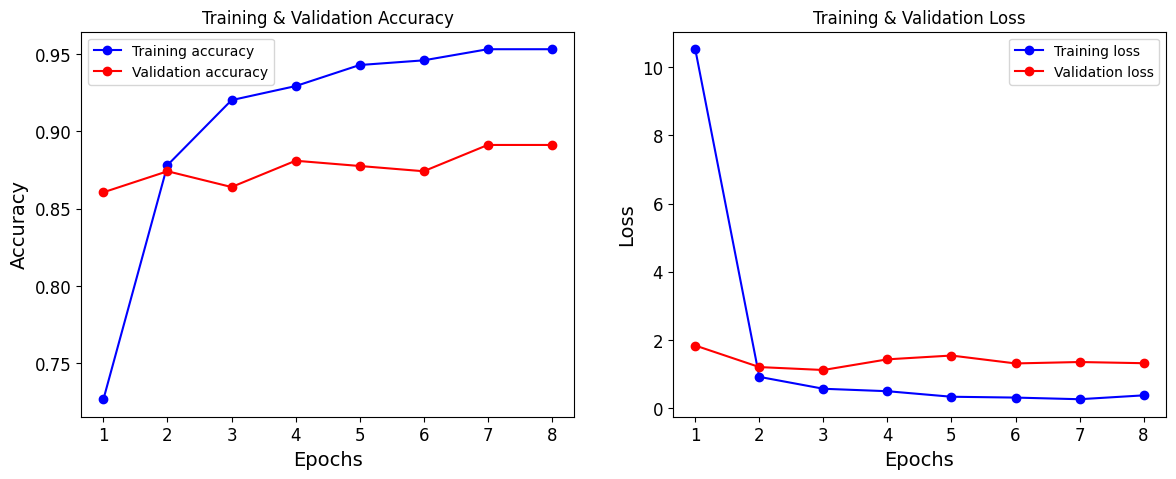

In [168]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1_1.history['accuracy']
val_acc = history_1_1.history['val_accuracy']
loss = history_1_1.history['loss']
val_loss = history_1_1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [169]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1_1.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8502 - loss: 1.1237
0.966710090637207 0.8623978495597839


Model 1_2: Changing the optimizer and reduce learning rate.

In [196]:
model_1_2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [197]:
# Compile the model
model_1_2.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [198]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

history_1_2 = model_1_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5703 - loss: 10.5175 - val_accuracy: 0.7619 - val_loss: 0.7761 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7128 - loss: 1.3721 - val_accuracy: 0.7823 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7537 - loss: 1.0809 - val_accuracy: 0.7925 - val_loss: 0.7023 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7725 - loss: 0.8294 - val_accuracy: 0.8163 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7952 - loss: 0.7167 - val_accuracy: 0.8129 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8339 - loss: 0.7744 - val_accuracy: 0.8129 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8113 - loss: 0.6144 - val_ac

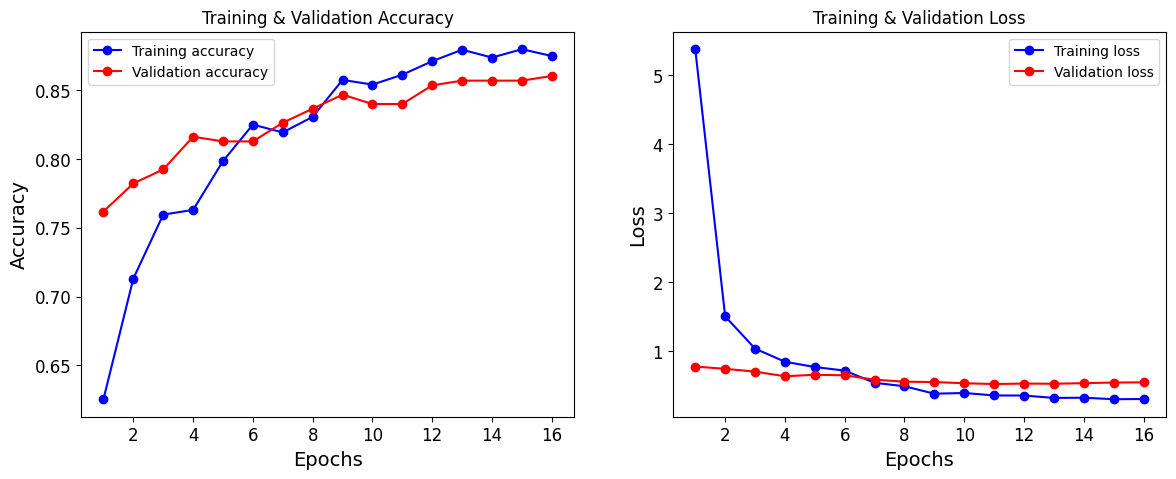

In [199]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1_2.history['accuracy']
val_acc = history_1_2.history['val_accuracy']
loss = history_1_2.history['loss']
val_loss = history_1_2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [200]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1_2.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8319 - loss: 0.7467
0.6549185514450073 0.8269754648208618


In [174]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)